# Entrenamiento O3


Una vez que se tienen los datos limpios y procesados, estos pueden ser usados para la generación de los modelos. A continuación se muestra el flujo trabajo para la generación de los modelos:

<img src="./gen_modelos.png" style="height:300px">

Los modelos utilizados son del tipo __supervisado___, esto quiere decir que se necesita tener el valor real para poder generar los modelos, este valor corresponde a la columna del contaminante a pronosticar a una hora específica.  

Una vez que se tiene esta columna identificado, es necesario dividir los datos de entrenamiento en dos conjuntos: de __entrenamiento__ y __prueba__. La razón de dividirlos es para poder cuantiﬁcar el desempeño y el correcto funcionamiento de los modelos. El conjunto de entrenamiento correspondió al __80%__ de los datos totales y en éste se ejecutarán los modelos estadísticos para obtener los árboles de decisión y con el conjunto de prueba que correspondió al __20%__ restante, se comparará el pronóstico de los modelos con el valor real.

Con el conjunto de entrenamiento se ejecutaron todas las pruebas realizadas, aplicando los modelos de machine learning ya mencionados. Los modelos se optimizaron para tener un correcto pronóstico de valores alrededor del nivel de contaminación de la contingencia ambiental. Los modelos de los tres contaminantes son capaces de generar el pronóstico hasta de 24 horas, para cada hora se generó un modelo de manera que se generaron 24 modelos.


### Métricas de Valoración
Para medir el desempeño de un modelo de pronóstico es importante contar con una métrica de desempeño. Medir el desempeño del pronóstico es importante para saber que los métodos y características con los que trabaja el pronóstico son los adecuados. Además, calcular el desempeño de los modelos nos ayudará en la búsqueda de partes del pronóstico que no trabajen de manera óptima y con esto tomar decisiones para mejorar el desempeño del mismo. Las principales métricas usadas para medir el desempeño del modelo son el RMSE que nos indica qué tanto se aleja la predicción del valor real, la R2 que determina la calidad del modelo para replicar los resultados y la proporción de variación de los resultados que puede explicarse por el modelo y la precisión que nos indica cuántos falsos positivos genera el modelo es decir, cuántas contingencias son pronosticadas incorrectamente por cada contingencia pronosticada correctamente.


__Pasos y descripción general del notebook__


- __Datos recibidos:__ Limpieza de datos inicial
- __Responsable:__ Daniel Bustillos
- __Contacto:__  juandaniel.bucam@gmail.com


In [1]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import missingno as msn

pd.options.mode.chained_assignment = None 

from sklearn.externals import joblib
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression

#### Hacemos una función para obtenner el -promedio- de los dos modelos

In [2]:
def predictor_mean(model0_1,modelo_2,X_set):  
    #aplicamos los predict
    forecast_q = model0_1.predict(X_set) 
    forecast = modelo_2.predict(X_set)
   #generamos una lista dummy: 
    forecast_mean = forecast 
    
    for i in range(len(X_set)):
        if  forecast[i] < 135:
            forecast_mean[i] = forecast[i]
        elif  forecast_q[i] > 160:
            forecast_mean[i] = forecast_q[i]
        if  130 < forecast_q[i] <155 and 130 < forecast[i] < 155:
            forecast_mean[i] = (0.3*forecast_q[i] + 0.7*forecast[i])
        if  140 < forecast_q[i] <160 and 140 < forecast[i] < 160:
            forecast_mean[i] = (forecast_q[i] + forecast[i])/2
    return forecast_mean

## Hacemos una función para graficar

In [25]:
def ploter(y_test_0,X_test_0,pronosticados_0,model):
    
    plt.scatter(y_test_0, pronosticados_0,alpha=0.5,color="royalblue")
    score = round(model.score(X_test_0, y_test_0),3)
    rmse = round(np.sqrt(mean_squared_error(y_test_0, pronosticados_0)),3)
    plt.plot([30,130],[30,130],color="k",linestyle='--')
    
    plt.axhline(y=155, color='k', linestyle='--')
    plt.axvline(x=155, color='k', linestyle='--')
    plt.annotate('TP', (170,150), xytext = (175, 155 + 1), 
                  horizontalalignment='right')
    plt.annotate('FN', (170,150), xytext = (175, 135 + 1), 
                  horizontalalignment='right')
    plt.annotate('FP', (170,150), xytext = (125, 155 + 1), 
                  horizontalalignment='right')
    plt.annotate('FP', (170,150), xytext = (125, 135 + 1), 
                  horizontalalignment='right')
    plt.annotate("Score ="+str(score), (15,139), xytext = (15, 139 + 1), 
                  horizontalalignment='left')
    plt.annotate("RMSE ="+str(rmse), (15,119), xytext = (15, 119 + 1), 
                  horizontalalignment='left')
    
    
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.title('Pronóstico con Persistencia Temporal')
    plt.show()

In [26]:
def ploter_title(y_test_0,X_test_0,pronosticados_0,model,titulo,ejex,ejey,color_user,ruta="./savedpicO3.png",dpi_user=300):
    
    plt.scatter(y_test_0, pronosticados_0,alpha=0.5,color=color_user)
    score = round(model.score(X_test_0, y_test_0),3)
    rmse = round(np.sqrt(mean_squared_error(y_test_0, pronosticados_0)),3)
    plt.plot([30,130],[30,130],color="k",linestyle='--')
    
    plt.axhline(y=155, color='k', linestyle='--')
    plt.axvline(x=155, color='k', linestyle='--')
    plt.annotate('TP', (170,150), xytext = (175, 155 + 1), 
                  horizontalalignment='right')
    plt.annotate('FN', (170,150), xytext = (175, 135 + 1), 
                  horizontalalignment='right')
    plt.annotate('FP', (170,150), xytext = (125, 155 + 1), 
                  horizontalalignment='right')
    plt.annotate('FP', (170,150), xytext = (125, 135 + 1), 
                  horizontalalignment='right')
    plt.annotate("Score ="+str(score), (15,139), xytext = (15, 139 + 1), 
                  horizontalalignment='left')
    plt.annotate("RMSE ="+str(rmse), (15,119), xytext = (15, 119 + 1), 
                  horizontalalignment='left')
    
    
    plt.xlabel(ejex)
    plt.ylabel(ejey)
    plt.title(titulo)
    plt.savefig(ruta, dpi=dpi_user)
    plt.show()

## Cargamos los modelos ya entrenados:

In [5]:
conta = 'O3'

In [6]:
model = [0 for col in range(25)]
modelq = [0 for col in range(25)]

#### Cargamos los datos:

In [56]:
data_hour_merge = pd.read_csv(str("/DATA/paw/jupyterhub_notebook/daniel.bustillos/DanielBustillos/"+
                                  "contaminación/pipeline_norberto_11horas/datos/datos_modelos_O3.csv"))

In [57]:
data_hour_merge[["fecha","O3_1.0_max","O3_max_frcst_1"]].tail(10)

,fecha,O3_1.0_max,O3_max_frcst_1
33606,2015-01-04 12:00:00,29.0,46.0
33607,2015-01-04 11:00:00,15.0,35.0
33608,2015-01-04 10:00:00,10.0,29.0
33609,2015-01-04 09:00:00,10.0,15.0
33610,2015-01-04 08:00:00,8.0,10.0
33611,2015-01-04 07:00:00,7.0,10.0
33612,2015-01-04 06:00:00,15.0,8.0
33613,2015-01-04 05:00:00,16.0,7.0
33614,2015-01-04 04:00:00,11.0,15.0
33615,2015-01-04 03:00:00,20.0,16.0


In [58]:
data_hour_merge.reset_index(inplace=True,drop=True)

In [33]:
list_hours = [4,5,6]

data_hour_merge= data_hour_merge[data_hour_merge["hora"].isin(list_hours)]
data_hour_merge.reset_index(inplace=True,drop=True)

In [59]:
data_hour_merge.drop("fecha",axis=1,inplace=True)

Definimos la lista de los targets:

In [60]:
target = "O3_max_frcst_"

lista = []
for i in range(1,25):
    lista.append(str(target+str(i)))

In [61]:
lista = []
for i in range(1,25):
    lista.append(str(target+str(i)))

In [62]:
conta = 'O3'

In [63]:
data_hour_merge.shape

(33616, 135)

# Empezamos con el entrenamiento:

#### HORA 1 

#### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [20]:
hora = 1

dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

#Definimos los conjuntos de prueba:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [21]:
X_train.shape

(23548, 106)

In [22]:
X_train.columns.tolist()

['TMP_2.0_max',
 'RH_22.0_max',
 'hora_11.0',
 'O3_47.0_max',
 'RH_22.0_min',
 'TMP_22.0_mean',
 'O3_1.0_max',
 'RH_48.0_mean',
 'RH_max',
 'RH_2.0_max',
 'O3_2.0_max',
 'O3_1.0_min',
 'RH_23.0_min',
 'RH_25.0_mean',
 'TMP_mean_frcst_24',
 'RH_0.0_mean',
 'TMP_24.0_mean',
 'hora_43.0',
 'hora_20.0',
 'O3_1.0_mean',
 'TMP_mean',
 'O3_44.0_mean',
 'TMP_0.0_max',
 'RH_0.0_max',
 'O3_2.0_min',
 'O3_0.0_max',
 'O3_45.0_max',
 'TMP_23.0_mean',
 'RH_0.0_min',
 'O3_23.0_max',
 'RH_mean_frcst_22',
 'TMP_24.0_max',
 'RH_47.0_mean',
 'TMP_mean_frcst_23',
 'TMP_0.0_min',
 'O3_24.0_mean',
 'TMP_max',
 'TMP_1.0_max',
 'WSP_44.0_mean',
 'O3_0.0_mean',
 'O3_23.0_min',
 'O3_46.0_max',
 'RH_mean_frcst_21',
 'RH_mean_frcst_1',
 'RH_mean_frcst_2',
 'TMP_21.0_max',
 'TMP_mean_frcst_2',
 'RH_2.0_min',
 'TMP_46.0_mean',
 'RH_24.0_min',
 'TMP_45.0_mean',
 'TMP_mean_frcst_3',
 'TMP_mean_frcst_1',
 'O3_min',
 'O3_mean',
 'O3_47.0_mean',
 'TMP_2.0_mean',
 'TMP_23.0_max',
 'O3_2.0_mean',
 'O3_21.0_max',
 'RH_23.0

## Modelo

In [23]:
from xgboost.sklearn import XGBRegressor

In [24]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=1500,random_state=123,max_depth=10)

In [25]:
model[0].fit(X_train, y_train)
#Predict 

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:24:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=1500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [26]:
pronos_1 = model[0].predict(X_test)

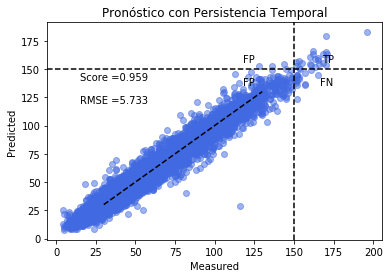

In [27]:
ploter(y_test,X_test,pronos_1,model[0])

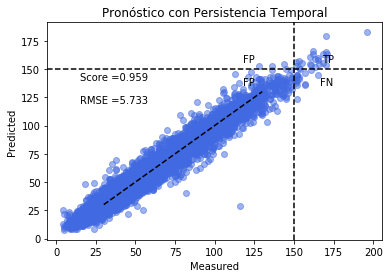

In [28]:
ploter(y_test,X_test,pronos_1,model[0])

In [29]:
# now you can save it to a file
joblib.dump(model[hora-1], './modelos/'+ conta +'/'+ conta +'_'+ str(hora)+ 'hora.pkl')

['./modelos/O3/O3_1hora.pkl']

## Gradienst Descent:

# HORA 2

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [30]:
hora = 2

In [31]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [32]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [33]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [35]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,random_state=123,max_depth=10)

In [36]:
model[1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:32:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [37]:
pronos_2_q = model[1].predict(X_test)

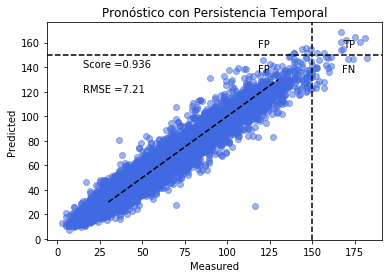

In [38]:
ploter(y_test,X_test,pronos_2_q,model[1])

In [39]:
# now you can save it to a file
joblib.dump(model[hora-1], './modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl')

['./modelos/O3/O3_2hora.pkl']

# HORA 3

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [40]:
hora = 3

In [41]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [42]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [43]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [45]:
model[hora-1] = XGBRegressor(learning_rate=0.05,n_estimaators=2500,n_jobs=124,random_state=123,max_depth=10, gamma=1.16)

In [46]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:48:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1.16,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimaators=2500,
       n_estimators=100, n_jobs=124, nthread=None, objective='reg:linear',
       random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

In [47]:
pronos_2_q = model[hora-1].predict(X_test)

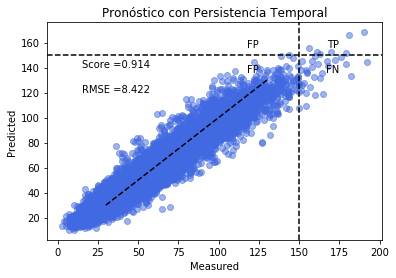

In [48]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [49]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_3hora.pkl']

# HORA 4

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [50]:
hora = 4

In [51]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [52]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [53]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [55]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [56]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:48:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [57]:
pronos_2_q = model[hora-1].predict(X_test)

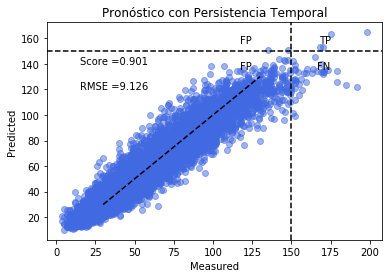

In [58]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [59]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_4hora.pkl']

# HORA 5

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [60]:
hora = 5

In [61]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [62]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [63]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [65]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [66]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:54:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [67]:
pronos_2_q = model[hora-1].predict(X_test)

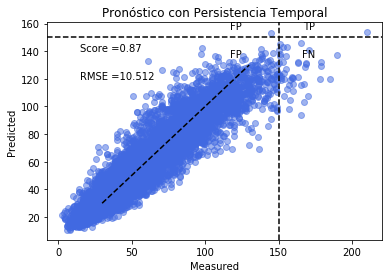

In [68]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

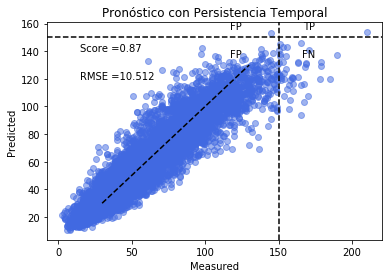

In [69]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [70]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_5hora.pkl']

# HORA 6

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [71]:
hora = 6

In [72]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [73]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [74]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [76]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [77]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:00:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [78]:
pronos_2_q = model[hora-1].predict(X_test)

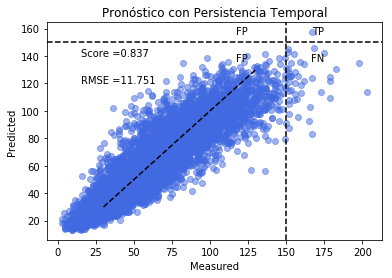

In [79]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [80]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_6hora.pkl']

# HORA 7

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [81]:
hora = 7

In [82]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [83]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [84]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [86]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [87]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:07:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [ ]:
pronos_2_q = model[hora-1].predict(X_test)

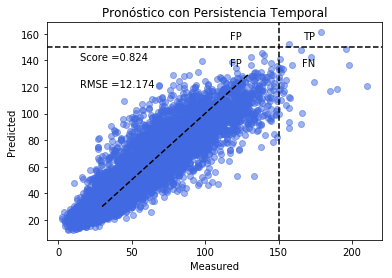

In [ ]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [ ]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_7hora.pkl']

# HORA 8

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [ ]:
hora = 8

In [ ]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [ ]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [ ]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [ ]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [ ]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:13:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [ ]:
pronos_2_q = model[hora-1].predict(X_test)

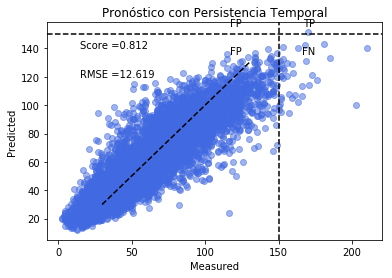

In [ ]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [ ]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_8hora.pkl']

# HORA 9

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [ ]:
hora = 9

In [ ]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [ ]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [ ]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [ ]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [ ]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:20:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [ ]:
pronos_2_q = model[hora-1].predict(X_test)

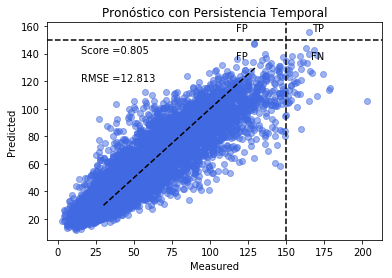

In [ ]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [ ]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_9hora.pkl']

# HORA 10

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [ ]:
hora = 10

In [ ]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [ ]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [ ]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [ ]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [ ]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:27:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [ ]:
pronos_2_q = model[hora-1].predict(X_test)

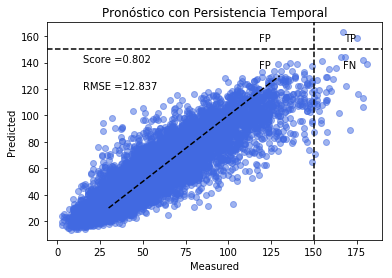

In [ ]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [ ]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_10hora.pkl']

# HORA 11

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [64]:
hora = 11

In [65]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [66]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [67]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [69]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [74]:
model[hora-1]  = XGBRegressor()

In [75]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:16:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [76]:
pronos_2_q = model[hora-1].predict(X_test)

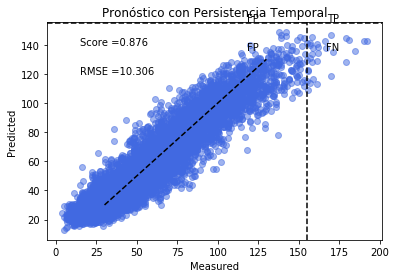

In [77]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [ ]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_11hora.pkl']

# HORA 12

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [ ]:
hora = 12

In [ ]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [ ]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [ ]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [ ]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [ ]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:40:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [ ]:
pronos_2_q = model[hora-1].predict(X_test)

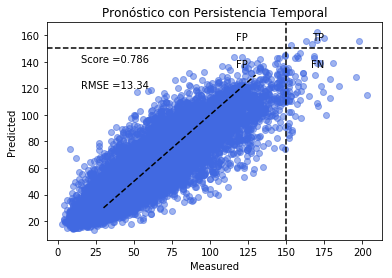

In [ ]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:45:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


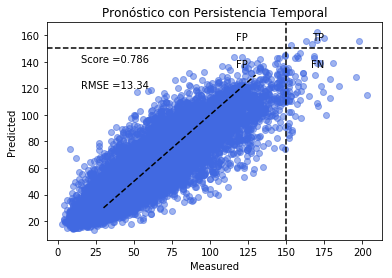

In [ ]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=133,max_depth=10,
                            gamma = 0.,colsample_bytree = 1,scale_pos_weight =1)
model[hora-1].fit(X_train, y_train)
pronos_2_q = model[hora-1].predict(X_test)
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [ ]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_12hora.pkl']

# HORA 13

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [ ]:
hora = 13

In [ ]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [ ]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [ ]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [ ]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [ ]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:49:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [ ]:
pronos_2_q = model[hora-1].predict(X_test)

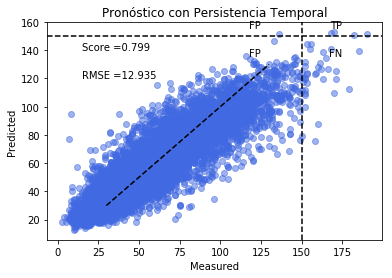

In [ ]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [ ]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_13hora.pkl']

# HORA 14

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [ ]:
hora = 14

In [ ]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [ ]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [ ]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [ ]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [ ]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:56:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [ ]:
pronos_2_q = model[hora-1].predict(X_test)

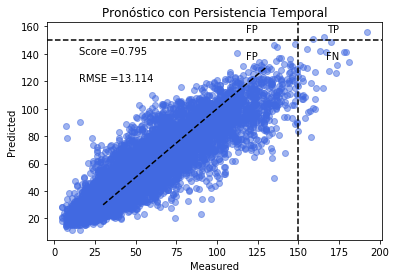

In [ ]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [ ]:
# now you can save it to a file
joblib.dump(model[hora-1], './modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl')

['./modelos/O3/O3_14hora.pkl']

# HORA 15

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [ ]:
hora = 15

In [ ]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [ ]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [ ]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [ ]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [ ]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:03:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [ ]:
pronos_2_q = model[hora-1].predict(X_test)

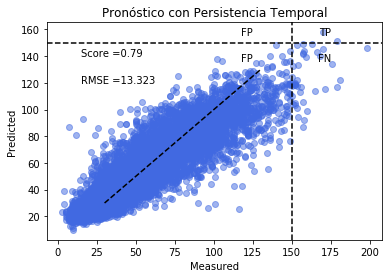

In [ ]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [ ]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_15hora.pkl']

# HORA 16

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [ ]:
hora = 16

In [ ]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [ ]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [ ]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [ ]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [ ]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:10:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [ ]:
pronos_2_q = model[hora-1].predict(X_test)

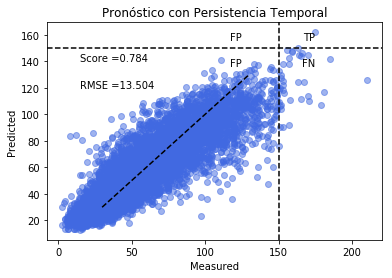

In [ ]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [ ]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_16hora.pkl']

# HORA 17

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [ ]:
hora = 17

In [ ]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [ ]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [ ]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [ ]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [ ]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:17:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [ ]:
pronos_2_q = model[hora-1].predict(X_test)

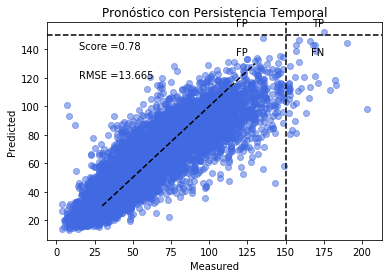

In [ ]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [ ]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_17hora.pkl']

# HORA 18

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [ ]:
hora = 18

In [ ]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [ ]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [ ]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [ ]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [ ]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:25:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [ ]:
pronos_2_q = model[hora-1].predict(X_test)

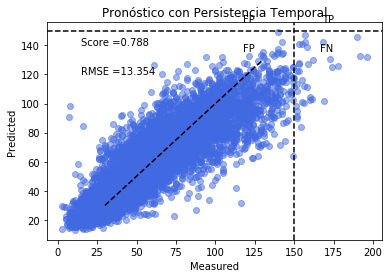

In [ ]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [ ]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+ conta+'_'+ str(hora) + 'hora.pkl') 

['./modelos/O3/O3_18hora.pkl']

# HORA 19

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [ ]:
 hora = 19

In [ ]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [ ]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [ ]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [ ]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [ ]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:32:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [ ]:
pronos_2_q = model[hora-1].predict(X_test)

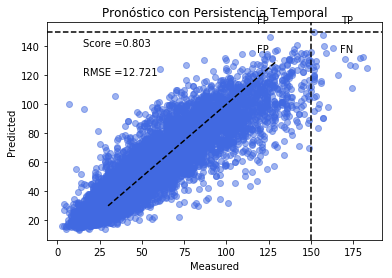

In [ ]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [ ]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_19hora.pkl']

# HORA 20

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [ ]:
hora = 20

In [ ]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [ ]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [ ]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [ ]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [ ]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:39:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
pronos_2_q = model[hora-1].predict(X_test)

In [ ]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [ ]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

# HORA 21

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [ ]:
hora = 21

In [223]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [224]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [225]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [226]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [227]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [228]:
model[hora-1].fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [229]:
pronos_2_q = model[hora-1].predict(X_test)

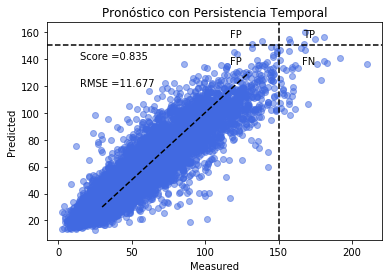

In [230]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [231]:
# now you can save it to a file
joblib.dump(model[hora-1], './modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl')

['./modelos/O3/O3_21hora.pkl']

## Hora 22

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [232]:
hora = 22

In [233]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [234]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [235]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [236]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [237]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [238]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:54:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [239]:
pronos_2_q = model[hora-1].predict(X_test)

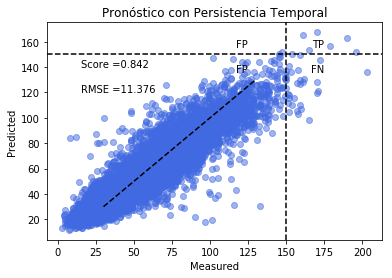

In [240]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [241]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_22hora.pkl']

# HORA 23

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [242]:
hora = 23

In [243]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [244]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [245]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [246]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [247]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [248]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:01:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [249]:
pronos_2_q = model[hora-1].predict(X_test)

In [250]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [251]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

# HORA 24

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [39]:
hora = 24

In [40]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [41]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [42]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [257]:
model[hora-1] = XGBRegressor(learning_rate=0.05,n_estimators=2500,n_jobs=1000,random_state=123,max_depth=10)

In [44]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=1500,n_jobs=100,random_state=123,max_depth=10,
                            gamma = 0.,colsample_bytree = 1,scale_pos_weight =1)

In [45]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:07:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=1500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [46]:
pronos_2_q = model[hora-1].predict(X_test)

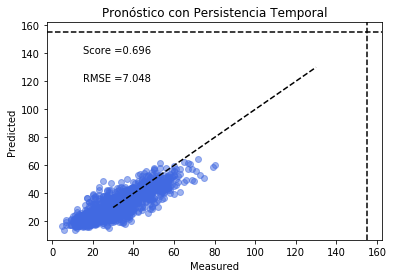

In [47]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])#XGBRegressor(learning_rate=0.1,n_estimators=2500,n_jobs=100,random_state=123,max_depth=3)

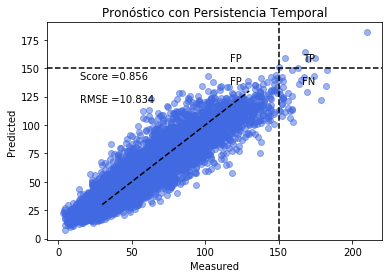

In [262]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])#XGBRegressor(learning_rate=0.1,n_estimators=2500,n_jobs=100,random_state=123,max_depth=3)

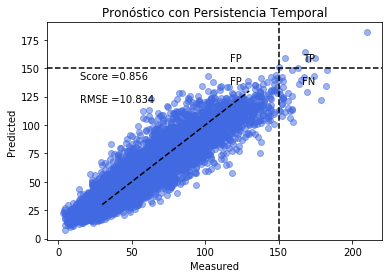

In [263]:
ploter(y_test,X_test,pronos_2_q,model[hora-1]) #XGBRegressor(learning_rate=0.1,n_estimators=2500,n_jobs=100,random_state=123,max_depth=3)

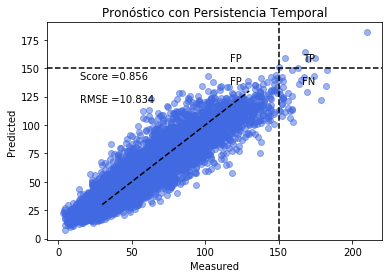

In [264]:
ploter(y_test,X_test,pronos_2_q,model[hora-1]) #XGBRegressor(learning_rate=0.1,n_estimators=2500,n_jobs=100,random_state=123,max_depth=5)

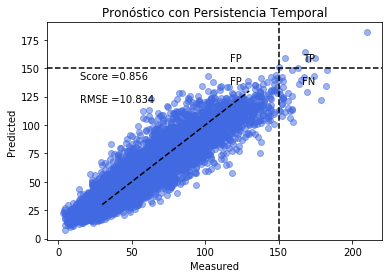

In [265]:
ploter(y_test,X_test,pronos_2_q,model[hora-1]) #XGBRegressor(learning_rate=0.1,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

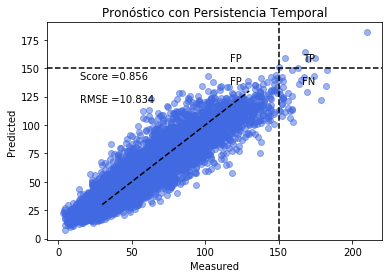

In [266]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])#XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [267]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_24hora.pkl']

# HORA 24 Test

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

### Prueba